In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
import random
#import keras_tuner as kt


### Cargue de los datos

In [16]:
# Cargar archivos (rutas relativas desde notebooks/)
train = pd.read_csv("../data/raw/train_data.csv")
test = pd.read_csv("../data/raw/test_data.csv")
sample_submission = pd.read_csv("../data/raw/sampleSubmission.csv")

## Ingenieria de variables

In [17]:
def extend_features(df): 
    # RATIOS COMBINADOS Y COMPUESTOS
    # Z-score modificado (versión de Altman para no manufactureras):
    # Versión modificada del Z-score (simplificado)
    df['Z_score_modificado'] = (
        1.2 * df['Working.Capital.to.Total.Assets'] +
        1.4 * df['Retained.Earnings.to.Total.Assets'] +
        3.3 * df['Operating.Profit.Rate'] +
        0.6 * df['Equity.to.Liability'] +
        1.0 * df['Revenue.per.person']  # Ajustado como proxy de ventas/activos
    )

    # Ratio de apalancamiento extendido
    df['Apalancamiento_Extendido'] = df['Total.debt.Total.net.worth'] + df['Contingent.liabilities.Net.worth']

    # DIFERENCIAS Y VARIACIONES TEMPORALES
    # Cambio en margen bruto vs margen operativo (eficiencia operativa)
    df['Cambio_Margen_Bruto'] = df['Gross.Profit.to.Sales'] - df['Operating.Gross.Margin']

    # INDICADORES DE SOLVENCIA Y ESTRES FINANCIERO
    # Indicador de estrés financiero: pasivos corrientes vs activos líquidos
    df['Stress_Financiero'] = df['Current.Liability.to.Current.Assets'] / (df['Cash.Total.Assets'] + 1e-6)

    # 4. Relación de liquidez con obligaciones: flujo de caja vs pasivos
    df['Liquidez_vs_Pasivos'] = df['Cash.Flow.to.Liability'] - df['Interest.Coverage.Ratio..Interest.expense.to.EBIT.']

    # 5. Bandera de alerta si flujo operativo es bajo y ratio de deuda alto
    df['Bandera_Bajo_Flujo_Operativo'] = np.where(
        (df['Cash.Flow.to.Sales'] < 0.05) & (df['Debt.ratio..'] > 0.7),
        1, 0
    )

    # 6. Variación de utilidad por acción entre temporadas (estabilidad)
    df['Volatilidad_EPS'] = df['Persistent.EPS.in.the.Last.Four.Seasons'].rolling(window=4, min_periods=1).std()

    # 7. Margen de beneficio después de impuestos
    df['Margen_Neto_Post_Impuestos'] = df['After.tax.Net.Profit.Growth.Rate'] / (df['Operating.Profit.Rate'] + 1e-6)

    # 8. Ratio de cobertura de obligaciones financieras
    df['Cobertura_Deuda'] = df['Operating.Profit.Rate'] / (df['Interest.bearing.debt.interest.rate'] + 1e-6)

    # 9. Capital de trabajo neto sobre activos totales
    df['Capital_Trabajo_Ratio'] = (df['Current.Assets.Total.Assets'] - df['Current.Liability.to.Assets'])
    
    return df

In [18]:
# Agregar nuevas variables
train = extend_features(train)
test = extend_features(test)

#### Verificación de valores vacios
Porque se crearon nuevas variables

In [19]:
# Porcentaje de valores nulos por columna
nulls = train.isnull().mean().sort_values(ascending=False)
nulls[nulls > 0]

Volatilidad_EPS    0.000488
dtype: float64

In [20]:
# Porcentaje de valores nulos por columna
nulls = test.isnull().mean().sort_values(ascending=False)
nulls[nulls > 0]

Volatilidad_EPS    0.002
dtype: float64

In [21]:
from sklearn.impute import SimpleImputer

# Separar features y target para que al imputar tengan las mismas columnas
X = train.drop(columns=["ID", "Bankruptcy"])
y_train = train["Bankruptcy"]

# Guardar ID del test para el submission
test_ids = test["ID"]
X_test = test.drop(columns=["ID"])

# Asegurarse de que X_test tenga las mismas columnas que X
X_test = X_test.reindex(columns=X.columns, fill_value=np.nan)

# Crear el imputer para la mediana
median_imputer = SimpleImputer(strategy='median')

# Aplicar el imputer a los datos de entrenamiento y prueba
X_train_imputed = pd.DataFrame(median_imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(median_imputer.transform(X_test), columns=X.columns)

### Normalización de los datos

In [22]:
# Dividir training en entrenamiento y validación
# X_train, X_val, y_train, y_val = train_test_split(X_train_imputed, y, test_size=0.2, stratify=y, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

#X_train_scaled[:3]  # Mostrar ejemplo de datos escalados

#### Variables seleccionadas

In [24]:
selected_features = ['Working.Capital.to.Total.Assets',
 'Retained.Earnings.to.Total.Assets',
 'Cash.Total.Assets',
 'Per.Share.Net.profit.before.tax..Yuan...',
 'Equity.to.Liability',
 'Net.Worth.Turnover.Rate..times.',
 'Revenue.per.person',
 'Cobertura_Deuda',
 'Total.expense.Assets',
 'ROA.B..before.interest.and.depreciation.after.tax',
 'Quick.Assets.Total.Assets',
 'Volatilidad_EPS',
 'Debt.ratio..',
 'Long.term.fund.suitability.ratio..A.',
 'CFO.to.Assets',
 'Operating.Profit.Rate',
 'Persistent.EPS.in.the.Last.Four.Seasons',
 'Interest.Coverage.Ratio..Interest.expense.to.EBIT.',
 'Operating.profit.per.person',
 'Current.Liability.to.Assets',
 'Net.Value.Per.Share..C.',
 'Net.Value.Per.Share..B.',
 'Current.Liability.to.Current.Assets',
 'Contingent.liabilities.Net.worth',
 'Fixed.Assets.to.Assets',
 'Operating.Gross.Margin',
 'Z_score_modificado',
 'Current.Assets.Total.Assets',
 'Fixed.Assets.Turnover.Frequency',
 'Cash.Flow.to.Liability',
 'Equity.to.Long.term.Liability',
 'Stress_Financiero',
 'Cambio_Margen_Bruto',
 'Operating.profit.Paid.in.capital',
 'Current.Liability.to.Liability',
 'Operating.Profit.Per.Share..Yuan...',
 'Working.Capital.Equity',
 'Cash.Flow.to.Sales',
 'Current.Liability.to.Equity',
 'Tax.rate..A.']

### Balance de los datos

In [25]:
from imblearn.over_sampling import SMOTE
# Filtrar las variables que superan el umbral de 5 de importancia
X_train_all_scaled_df = pd.DataFrame(X_train_all_scaled, columns=X_train_imputed.columns)
# Subconjunto de datos con esas variables
X_train_sub = X_train_all_scaled_df[selected_features]


# Aplicar SMOTE para balancear clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_sub, y_train)

### Redes Neuronales


Epoch 1/30
Train F1: 0.0

Epoch 2/30
Train F1: 0.0

Epoch 3/30
Train F1: 0.0

Epoch 4/30
Train F1: 0.0

Epoch 5/30
Train F1: 0.0317

Epoch 6/30
Train F1: 0.0317

Epoch 7/30
Train F1: 0.0625

Epoch 8/30
Train F1: 0.0923

Epoch 9/30
Train F1: 0.0909

Epoch 10/30
Train F1: 0.1194

Epoch 11/30
Train F1: 0.1739

Epoch 12/30
Train F1: 0.2

Epoch 13/30
Train F1: 0.2

Epoch 14/30
Train F1: 0.2

Epoch 15/30
Train F1: 0.2

Epoch 16/30
Train F1: 0.1471

Epoch 17/30
Train F1: 0.2

Epoch 18/30
Train F1: 0.2254

Epoch 19/30
Train F1: 0.2254

Epoch 20/30
Train F1: 0.32

Epoch 21/30
Train F1: 0.25

Epoch 22/30
Train F1: 0.2254

Epoch 23/30
Train F1: 0.2254

Epoch 24/30
Train F1: 0.32

Epoch 25/30
Train F1: 0.274

Epoch 26/30
Train F1: 0.274

Epoch 27/30
Train F1: 0.25

Epoch 28/30
Train F1: 0.274

Epoch 29/30
Train F1: 0.3377

Epoch 30/30
Train F1: 0.3333

Final Train F1 Score: 0.3333
Final Train AUC Score: 0.956


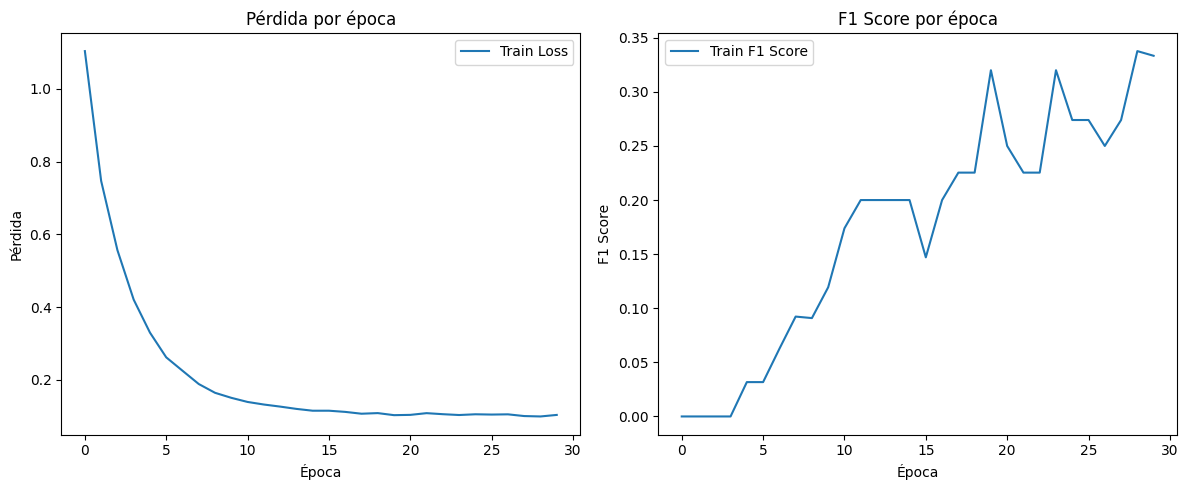

In [26]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, roc_auc_score

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_sub.shape[1],), 
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Inicializar listas para F1 y AUC por época
train_f1_scores = []

# Entrenamiento manual por época para registrar F1 en cada una
epochs = 30
batch_size = 32
history = {'loss': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Entrenar una época
    hist = model.fit(X_train_sub, y_train,
                     epochs=1,
                     batch_size=batch_size,
                     verbose=0)

    # Guardar pérdida
    history['loss'].append(hist.history['loss'][0])

    # Predicciones entrenamiento
    train_proba = model.predict(X_train_sub, verbose=0)
    train_pred = (train_proba > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_pred)
    train_f1_scores.append(train_f1)

    print(f"Train F1: {round(train_f1, 4)}")

# Calcular métricas finales
final_train_auc = roc_auc_score(y_train, train_proba)
final_train_f1 = f1_score(y_train, train_pred)
print(f"\nFinal Train F1 Score: {round(final_train_f1, 4)}")
print(f"Final Train AUC Score: {round(final_train_auc, 4)}")

# Graficar pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Graficar F1 Scores
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.title("F1 Score por época")
plt.xlabel("Época")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


#### Predicción en X_test

In [12]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

# Subconjunto de datos con esas variables
X_test_sub = X_test_scaled_df[selected_features]

# Predicción final en test
test_predictions = model.predict(X_test_sub)

16/16 [==============================] - 0s 769us/step


In [13]:
# El ID está en una columna llamada 'ID'
submission_df = pd.DataFrame({
    'ID': test['ID'],
    'Bankruptcy': test_predictions.flatten()
})

# Guardar el archivo correctamente
submission_df.to_csv("../results/submission_SF1_comp.csv", index=False)

# Verificar
submission_df.head()

,ID,Bankruptcy
0,5,0.005359
1,14,0.129620
2,16,0.013914
3,26,0.012328
4,28,0.002563


### Competencia

In [14]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, roc_auc_score

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(40, activation='relu', input_shape=(X_train_sub.shape[1],),
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.8),
    layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.8),
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Inicializar listas para métricas
train_f1_scores = []
train_auc_scores = []
history = {'loss': [], 'accuracy': []}

# Entrenamiento manual por época
epochs = 50
batch_size = 32

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Entrenar una época
    hist = model.fit(X_train_sub, y_train,
                     epochs=1,
                     batch_size=batch_size,
                     verbose=0)

    # Guardar pérdida y exactitud
    history['loss'].append(hist.history['loss'][0])
    history['accuracy'].append(hist.history['accuracy'][0])

    # Predicciones entrenamiento
    train_proba = model.predict(X_train_sub, verbose=0)
    train_pred = (train_proba > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_pred)
    train_auc = roc_auc_score(y_train, train_proba)

    train_f1_scores.append(train_f1)
    train_auc_scores.append(train_auc)

    print(f"Train F1: {round(train_f1, 4)} | Train AUC: {round(train_auc, 4)}")

# Resultados finales
final_train_f1 = train_f1_scores[-1]
final_train_auc = train_auc_scores[-1]
print(f"\nFinal Train F1 Score: {round(final_train_f1, 4)}")
print(f"Final Train AUC Score: {round(final_train_auc, 4)}")

# Graficar métricas
plt.figure(figsize=(15, 5))

# Pérdida
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Train Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Exactitud
plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.title("Exactitud por época")
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.legend()

# F1 y AUC
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='F1 Score')
plt.plot(train_auc_scores, label='AUC')
plt.title("F1 y AUC por época")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.legend()

plt.tight_layout()
plt.show()



Epoch 1/50
Train F1: 0.0 | Train AUC: 0.4342

Epoch 2/50
Train F1: 0.0 | Train AUC: 0.4035

Epoch 3/50
Train F1: 0.0 | Train AUC: 0.4592

Epoch 4/50
Train F1: 0.0 | Train AUC: 0.5258

Epoch 5/50
Train F1: 0.0 | Train AUC: 0.5945

Epoch 6/50
Train F1: 0.0 | Train AUC: 0.6603

Epoch 7/50
Train F1: 0.0 | Train AUC: 0.7207

Epoch 8/50
Train F1: 0.0 | Train AUC: 0.7635

Epoch 9/50
Train F1: 0.0 | Train AUC: 0.8002

Epoch 10/50
Train F1: 0.0 | Train AUC: 0.8233

Epoch 11/50
Train F1: 0.0 | Train AUC: 0.8415

Epoch 12/50
Train F1: 0.0 | Train AUC: 0.8553

Epoch 13/50
Train F1: 0.0 | Train AUC: 0.8662

Epoch 14/50
Train F1: 0.0 | Train AUC: 0.8771

Epoch 15/50
Train F1: 0.0 | Train AUC: 0.8865

Epoch 16/50
Train F1: 0.0 | Train AUC: 0.8984

Epoch 17/50
Train F1: 0.0 | Train AUC: 0.9085

Epoch 18/50
Train F1: 0.0 | Train AUC: 0.9151

Epoch 19/50
Train F1: 0.0 | Train AUC: 0.9197

Epoch 20/50
Train F1: 0.0 | Train AUC: 0.926

Epoch 21/50
Train F1: 0.0 | Train AUC: 0.932

Epoch 22/50
Train F1: 0

KeyboardInterrupt: 

In [ ]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

# Subconjunto de datos con esas variables
X_test_sub = X_test_scaled_df[selected_features]

# Predicción final en test
test_predictions = model.predict(X_test_sub)

16/16 [==============================] - 0s 870us/step


In [ ]:
# El ID está en una columna llamada 'ID'
submission_df = pd.DataFrame({
    'ID': test['ID'],
    'Bankruptcy': test_predictions.flatten()
})

# Guardar el archivo correctamente
submission_df.to_csv("../results/submission_SF8_manual_comp.csv", index=False)

# Verificar
submission_df.head()

,ID,Bankruptcy
0,5,0.007324
1,14,0.068151
2,16,0.012033
3,26,0.013039
4,28,0.004516


## Comp 2


Epoch 1/100
Train F1: 0.1143 | Train AUC: 0.5067

Epoch 2/100
Train F1: 0.0 | Train AUC: 0.4692

Epoch 3/100
Train F1: 0.0 | Train AUC: 0.503

Epoch 4/100
Train F1: 0.0 | Train AUC: 0.5599

Epoch 5/100
Train F1: 0.0 | Train AUC: 0.6203

Epoch 6/100
Train F1: 0.0 | Train AUC: 0.6803

Epoch 7/100
Train F1: 0.0 | Train AUC: 0.7375

Epoch 8/100
Train F1: 0.0 | Train AUC: 0.7955

Epoch 9/100
Train F1: 0.0 | Train AUC: 0.8414

Epoch 10/100
Train F1: 0.0 | Train AUC: 0.8648

Epoch 11/100
Train F1: 0.0 | Train AUC: 0.8884

Epoch 12/100
Train F1: 0.0 | Train AUC: 0.9003

Epoch 13/100
Train F1: 0.0 | Train AUC: 0.9041

Epoch 14/100
Train F1: 0.0 | Train AUC: 0.9189

Epoch 15/100
Train F1: 0.0 | Train AUC: 0.9249

Epoch 16/100
Train F1: 0.0 | Train AUC: 0.9333

Epoch 17/100
Train F1: 0.0 | Train AUC: 0.9369

Epoch 18/100
Train F1: 0.0 | Train AUC: 0.9372

Epoch 19/100
Train F1: 0.0 | Train AUC: 0.9385

Epoch 20/100
Train F1: 0.0 | Train AUC: 0.9405

Epoch 21/100
Train F1: 0.0 | Train AUC: 0.9411

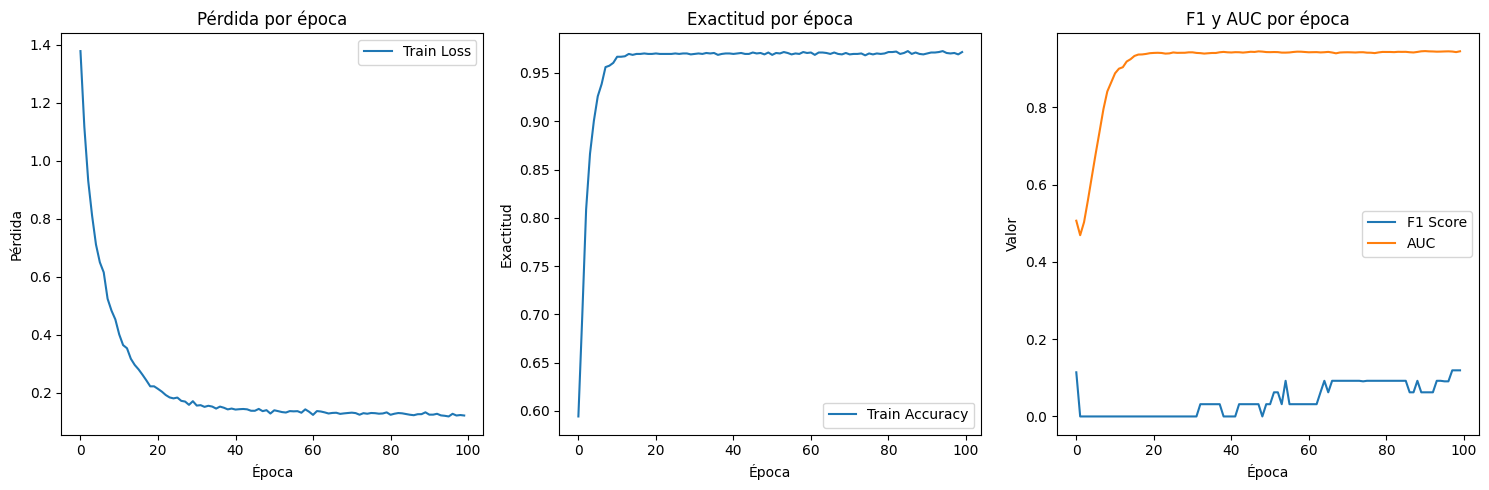

In [27]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, roc_auc_score
from keras.optimizers import SGD

# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Definir modelo base con regularización L2 y Dropout
model = models.Sequential([
    layers.Dense(40, activation='gelu', input_shape=(X_train_sub.shape[1],),
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Disminuir L2 regularization
    layers.Dropout(0.8),  # Disminuir Dropout
    layers.Dense(20, activation='silu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),  # L2 regularization
    layers.Dropout(0.8),  # Dropout regularization
    layers.Dense(1, activation='sigmoid')
])

# Compilar modelo con tasa de aprendizaje ajustada
model.compile(optimizer=Adam(learning_rate=0.001),  # Ajuste de tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.5),  # Ajuste de tasa de aprendizaje
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

# Inicializar listas para F1 y AUC por época
train_f1_scores = []
train_auc_scores = []
history = {'loss': [], 'accuracy': []}


# Entrenamiento manual por época para registrar F1 en cada una
epochs = 100
batch_size = 32

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Entrenar una época
    hist = model.fit(X_train_sub, y_train,
                     epochs=1,
                     batch_size=batch_size,
                     verbose=0)

    # Guardar pérdida y exactitud
    history['loss'].append(hist.history['loss'][0])
    history['accuracy'].append(hist.history['accuracy'][0])

    # Predicciones entrenamiento
    train_proba = model.predict(X_train_sub, verbose=0)
    train_pred = (train_proba > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_pred)
    train_auc = roc_auc_score(y_train, train_proba)

    train_f1_scores.append(train_f1)
    train_auc_scores.append(train_auc)

    print(f"Train F1: {round(train_f1, 4)} | Train AUC: {round(train_auc, 4)}")

# Resultados finales
final_train_f1 = train_f1_scores[-1]
final_train_auc = train_auc_scores[-1]
print(f"\nFinal Train F1 Score: {round(final_train_f1, 4)}")
print(f"Final Train AUC Score: {round(final_train_auc, 4)}")

# Graficar métricas
plt.figure(figsize=(15, 5))

# Pérdida
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Train Loss')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

# Exactitud
plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.title("Exactitud por época")
plt.xlabel("Época")
plt.ylabel("Exactitud")
plt.legend()

# F1 y AUC
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='F1 Score')
plt.plot(train_auc_scores, label='AUC')
plt.title("F1 y AUC por época")
plt.xlabel("Época")
plt.ylabel("Valor")
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

# Subconjunto de datos con esas variables
X_test_sub = X_test_scaled_df[selected_features]

# Predicción final en test
test_predictions = model.predict(X_test_sub)

16/16 [==============================] - 0s 822us/step


In [29]:
# El ID está en una columna llamada 'ID'
submission_df = pd.DataFrame({
    'ID': test['ID'],
    'Bankruptcy': test_predictions.flatten()
})

# Guardar el archivo correctamente
submission_df.to_csv("../results/submission_SF19_manual_comp.csv", index=False)

# Verificar
submission_df.head()

,ID,Bankruptcy
0,5,0.004004
1,14,0.069248
2,16,0.009352
3,26,0.013373
4,28,0.002662
